In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("dhoogla/unswnb15")

df=pd.read_parquet(path)
df.head()


,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sload,...,trans_depth,response_body_len,ct_src_dport_ltm,ct_dst_sport_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,is_sm_ips_ports,attack_cat,label
0,0.000011,udp,-,INT,2,0,496,0,90909.09375,180363632.0,...,0,0,1,1,0,0,0,0,Normal,0
1,0.000008,udp,-,INT,2,0,1762,0,125000.00000,881000000.0,...,0,0,1,1,0,0,0,0,Normal,0
2,0.000005,udp,-,INT,2,0,1068,0,200000.00000,854400000.0,...,0,0,1,1,0,0,0,0,Normal,0
3,0.000006,udp,-,INT,2,0,900,0,166666.65625,600000000.0,...,0,0,2,1,0,0,0,0,Normal,0
4,0.000010,udp,-,INT,2,0,2126,0,100000.00000,850400000.0,...,0,0,2,1,0,0,0,0,Normal,0


In [3]:
# Drop non-numeric columns before calculating the correlation matrix
numeric_df = df.select_dtypes(include=['number'])

# Calculate the correlation matrix
correlation_matrix = numeric_df.corr()

# Sort correlations with the 'label' column
if 'label' in correlation_matrix:
    print(correlation_matrix['label'].sort_values(ascending=False))
else:
    print("The 'label' column is not numeric or is missing in the correlation matrix.")



label                1.000000
ct_dst_sport_ltm     0.371672
rate                 0.335883
ct_src_dport_ltm     0.318518
sload                0.165249
dur                  0.029096
sbytes               0.019376
trans_depth          0.002246
sloss                0.001828
ackdat               0.000817
is_ftp_login        -0.008762
ct_ftp_cmd          -0.009092
ct_flw_http_mthd    -0.012237
sjit                -0.016436
response_body_len   -0.018930
tcprtt              -0.024668
smean               -0.028372
dinpkt              -0.030136
spkts               -0.043040
synack              -0.043250
djit                -0.048819
dbytes              -0.060403
dloss               -0.075961
dpkts               -0.097394
sinpkt              -0.155454
is_sm_ips_ports     -0.160126
dtcpb               -0.263543
stcpb               -0.266585
dmean               -0.295173
dwin                -0.339166
dload               -0.352169
swin                -0.364877
Name: label, dtype: float64


## stage 0 and 1

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import logging
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    roc_curve, roc_auc_score, precision_recall_fscore_support,
    precision_recall_curve, average_precision_score
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

class NetworkIntrusionModelComparator:
    def __init__(self, random_state=42):
        self.random_state = random_state
        self.models = {
            "Decision Tree": DecisionTreeClassifier(random_state=random_state),
            "Random Forest": RandomForestClassifier(
                n_estimators=100,
                max_depth=10,
                random_state=random_state
            ),
            "Neural Network": None
        }
        self.encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
        self.scaler = StandardScaler()
        self.results = {}
        self.X_train = self.X_test = self.y_train = self.y_test = None
        
        # Configure logging
        logging.basicConfig(
            level=logging.INFO,
            format='%(asctime)s - %(levelname)s - %(message)s'
        )
        
    def _is_numeric_column(self, series):
        """Check if a column is numeric by attempting conversion to float."""
        try:
            pd.to_numeric(series, errors='raise')
            return True
        except (ValueError, TypeError):
            return False
            
    def preprocess_data(self, data, target_col="label", attack_cat_col="attack_cat", test_size=0.2):
        """
        Preprocess the network traffic data with enhanced error handling and validation.
        
        Parameters:
        -----------
        data : pandas.DataFrame
            Input dataset containing network traffic features
        target_col : str
            Name of the target column (default: "label")
        attack_cat_col : str
            Name of the attack category column to be dropped (default: "attack_cat")
        test_size : float
            Proportion of dataset to include in the test split (default: 0.2)
            
        Returns:
        --------
        tuple
            Processed (X_train, X_test, y_train, y_test)
        """
        logging.info("Starting data preprocessing...")
        
        # Input validation
        if not isinstance(data, pd.DataFrame):
            raise ValueError("Input data must be a pandas DataFrame")
        
        required_cols = [target_col, attack_cat_col]
        missing_cols = [col for col in required_cols if col not in data.columns]
        if missing_cols:
            raise ValueError(f"Missing required columns: {missing_cols}")
            
        df = data.copy()
        
        # Handle infinite values
        df = df.replace([np.inf, -np.inf], np.nan)
        
        # Split features and target
        y = df[target_col]
        X = df.drop([target_col, attack_cat_col], axis=1)
        
        # Identify column types
        self.categorical_cols = [col for col in X.columns 
                               if not self._is_numeric_column(X[col])]
        self.numerical_cols = [col for col in X.columns 
                             if col not in self.categorical_cols]
        
        logging.info(f"Found {len(self.categorical_cols)} categorical and {len(self.numerical_cols)} numerical columns")
        
        # Enhanced missing value handling with logging
        for col in self.categorical_cols:
            missing = X[col].isna().sum()
            if missing > 0:
                mode_val = X[col].mode()[0]
                X[col].fillna(mode_val, inplace=True)
                logging.info(f"Filled {missing} missing values in {col} with mode: {mode_val}")
        
        for col in self.numerical_cols:
            missing = X[col].isna().sum()
            if missing > 0:
                median_val = X[col].median()
                X[col].fillna(median_val, inplace=True)
                logging.info(f"Filled {missing} missing values in {col} with median: {median_val}")
        
        # Feature processing
        if self.categorical_cols:
            X[self.categorical_cols] = X[self.categorical_cols].astype(str)
            encoded = pd.DataFrame(
                self.encoder.fit_transform(X[self.categorical_cols]),
                columns=self.encoder.get_feature_names_out(self.categorical_cols)
            )
            X = X.drop(self.categorical_cols, axis=1)
            X = pd.concat([X, encoded], axis=1)
        
        if self.numerical_cols:
            X[self.numerical_cols] = self.scaler.fit_transform(X[self.numerical_cols])
        
        # Train-test split
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=test_size, random_state=self.random_state, stratify=y
        )
        
        logging.info(f"Final preprocessed shape: {X.shape}")
        logging.info(f"Train set size: {len(self.X_train)}, Test set size: {len(self.X_test)}")
        
        return self.X_train, self.X_test, self.y_train, self.y_test

    def _build_neural_network(self, input_shape):
        """
        Build neural network with improved architecture and regularization.
        """
        model = Sequential([
            Dense(128, activation='relu', input_shape=(input_shape,)),
            Dropout(0.3),
            Dense(64, activation='relu'),
            Dropout(0.2),
            Dense(32, activation='relu'),
            Dense(1, activation='sigmoid')
        ])
        model.compile(
            optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy', 'AUC']
        )
        return model

    def train_models(self, cv_folds=5):
        """
        Train all models with cross-validation and early stopping for neural network.
        """
        for name, model in self.models.items():
            logging.info(f"Training {name}...")
            
            if name == "Neural Network":
                nn_model = self._build_neural_network(self.X_train.shape[1])
                early_stopping = EarlyStopping(
                    monitor='val_loss',
                    patience=3,
                    restore_best_weights=True
                )
                
                history = nn_model.fit(
                    self.X_train, self.y_train,
                    validation_data=(self.X_test, self.y_test),
                    epochs=50,
                    batch_size=32,
                    callbacks=[early_stopping],
                    verbose=1
                )
                
                self.models[name] = nn_model
                self.results[name] = {
                    "model": nn_model,
                    "history": history,
                    "y_pred": (nn_model.predict(self.X_test) > 0.5).astype(int)
                }
            else:
                # Cross-validation for sklearn models
                cv_scores = cross_val_score(
                    model, self.X_train, self.y_train, 
                    cv=cv_folds, scoring='accuracy'
                )
                logging.info(f"{name} CV Accuracy: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
                
                model.fit(self.X_train, self.y_train)
                y_pred = model.predict(self.X_test)
                
                self.results[name] = {
                    "model": model,
                    "y_pred": y_pred,
                    "cv_scores": cv_scores
                }
        
        return self

    def evaluate_models(self):
        """
        Generate comprehensive evaluation metrics for all models.
        """
        metrics = {}
        for name, result in self.results.items():
            y_pred = result["y_pred"]
            
            # Basic metrics
            precision, recall, f1, _ = precision_recall_fscore_support(
                self.y_test, y_pred, average="binary"
            )
            
            # Confusion matrix metrics
            cm = confusion_matrix(self.y_test, y_pred)
            tn, fp, fn, tp = cm.ravel()
            specificity = tn / (tn + fp)
            
            metrics[name] = {
                "precision": precision,
                "recall": recall,
                "f1": f1,
                "specificity": specificity,
                "accuracy": (tp + tn) / (tp + tn + fp + fn)
            }
            
            # AUC-ROC and AUC-PR for models with predict_proba
            if hasattr(result["model"], "predict_proba"):
                y_proba = result["model"].predict_proba(self.X_test)[:, 1]
                metrics[name].update({
                    "auc_roc": roc_auc_score(self.y_test, y_proba),
                    "auc_pr": average_precision_score(self.y_test, y_proba)
                })
            elif name == "Neural Network":
                y_proba = result["model"].predict(self.X_test)
                metrics[name].update({
                    "auc_roc": roc_auc_score(self.y_test, y_proba),
                    "auc_pr": average_precision_score(self.y_test, y_proba)
                })
            
            # Add cross-validation scores if available
            if "cv_scores" in result:
                metrics[name]["cv_accuracy_mean"] = result["cv_scores"].mean()
                metrics[name]["cv_accuracy_std"] = result["cv_scores"].std()
        
        return pd.DataFrame(metrics).T

    def plot_roc_curves(self):
        """Plot ROC curves with enhanced visualization."""
        plt.figure(figsize=(10, 6))
        
        for name, result in self.results.items():
            if hasattr(result["model"], "predict_proba"):
                y_proba = result["model"].predict_proba(self.X_test)[:, 1]
            elif name == "Neural Network":
                y_proba = result["model"].predict(self.X_test)
            else:
                continue
                
            fpr, tpr, _ = roc_curve(self.y_test, y_proba)
            auc = roc_auc_score(self.y_test, y_proba)
            plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})")
        
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curves Comparison")
        plt.legend(loc="lower right")
        plt.grid(True, alpha=0.3)
        return plt

    def plot_precision_recall_curves(self):
        """Plot precision-recall curves for all models."""
        plt.figure(figsize=(10, 6))
        
        for name, result in self.results.items():
            if hasattr(result["model"], "predict_proba"):
                y_proba = result["model"].predict_proba(self.X_test)[:, 1]
            elif name == "Neural Network":
                y_proba = result["model"].predict(self.X_test)
            else:
                continue
                
            precision, recall, _ = precision_recall_curve(self.y_test, y_proba)
            ap = average_precision_score(self.y_test, y_proba)
            plt.plot(recall, precision, label=f"{name} (AP = {ap:.3f})")
        
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title("Precision-Recall Curves")
        plt.legend(loc="lower left")
        plt.grid(True, alpha=0.3)
        return plt

    def plot_confusion_matrices(self):
        """Plot confusion matrices with improved visualization."""
        n_models = len(self.models)
        fig, axes = plt.subplots(1, n_models, figsize=(5*n_models, 5))
        if n_models == 1:
            axes = [axes]
            
        for ax, (name, result) in zip(axes, self.results.items()):
            cm = confusion_matrix(self.y_test, result["y_pred"])
            sns.heatmap(
                cm, 
                annot=True, 
                fmt='d', 
                ax=ax, 
                cmap='Blues',
                cbar=False
            )
            ax.set_title(f"{name}\nAccuracy: {(cm[0,0] + cm[1,1])/cm.sum():.3f}")
            ax.set_xlabel("Predicted")
            ax.set_ylabel("Actual")
        
        plt.tight_layout()
        return plt

    def plot_learning_curves(self):
        """Plot learning curves for the neural network with metrics."""
        if "Neural Network" not in self.results:
            logging.warning("No neural network results available")
            return None
            
        history = self.results["Neural Network"]["history"]
        metrics = history.history.keys()
        
        n_metrics = len(metrics) // 2  # Divide by 2 for train/val pairs
        fig, axes = plt.subplots(1, n_metrics, figsize=(6*n_metrics, 5))
        if n_metrics == 1:
            axes = [axes]
            
        for i, metric in enumerate([m for m in metrics if not m.startswith('val_')]):
            axes[i].plot(history.history[metric], label=f'Train {metric}')
            axes[i].plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
            axes[i].set_title(f"Neural Network {metric.capitalize()}")
            axes[i].set_xlabel("Epoch")
            axes[i].set_ylabel(metric.capitalize())
            axes[i].legend()
            axes[i].grid(True, alpha=0.3)
        
        plt.tight_layout()
        return plt

In [5]:


import numpy as np
from sklearn.neighbors import NearestNeighbors
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import logging

class Oversampling:
    def __init__(self, random_state=42, log_level=logging.INFO):
        """
        Initialize Oversampling with logging configuration.
        
        Parameters:
        -----------
        random_state : int, default=42
            Random state for reproducibility
        log_level : int, default=logging.INFO
            Logging level (DEBUG, INFO, WARNING, ERROR, CRITICAL)
        """
        self.random_state = random_state
        np.random.seed(random_state)
        
        # Configure logging
        self.logger = logging.getLogger(__name__)
        self.logger.setLevel(log_level)
        
        # Create console handler if none exists
        if not self.logger.handlers:
            ch = logging.StreamHandler()
            ch.setLevel(log_level)
            formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
            ch.setFormatter(formatter)
            self.logger.addHandler(ch)
        
    def _get_neighbors(self, X, k):
        """Find k-nearest neighbors for all samples."""
        self.logger.debug(f"Finding {k} nearest neighbors for {X.shape[0]} samples")
        
        neigh = NearestNeighbors(n_neighbors=k + 1)
        neigh.fit(X)
        distances, indices = neigh.kneighbors(X)
        
        self.logger.debug("Nearest neighbors search completed")
        return distances[:, 1:], indices[:, 1:]
    
    def smote(self, X, y, k=5, sampling_strategy=1.0):
        """Implementation of SMOTE with logging."""
        self.logger.info("Starting SMOTE oversampling")
        self.logger.info(f"Parameters: k={k}, sampling_strategy={sampling_strategy}")
        
        X = np.array(X)
        y = np.array(y)
        
        # Log initial class distribution
        counter = Counter(y)
        self.logger.info(f"Initial class distribution: {dict(counter)}")
        
        majority_class = max(counter, key=counter.get)
        minority_class = min(counter, key=counter.get)
        
        minority_indices = np.where(y == minority_class)[0]
        X_minority = X[minority_indices]
        
        n_minority = counter[minority_class]
        n_majority = counter[majority_class]
        n_synthetic = int(n_majority * sampling_strategy) - n_minority
        
        self.logger.info(f"Need to generate {n_synthetic} synthetic samples")
        
        if n_synthetic <= 0:
            self.logger.warning("No synthetic samples needed. Check sampling_strategy parameter.")
            return X, y
        
        _, nn_indices = self._get_neighbors(X_minority, k)
        
        # Generate synthetic samples
        synthetic_samples = []
        num_samples = n_synthetic
        
        self.logger.info("Generating synthetic samples...")
        generation_progress = 0
        progress_step = max(n_synthetic // 10, 1)  # Log every 10% or each sample if < 10
        
        while num_samples > 0:
            for i in range(len(X_minority)):
                if num_samples <= 0:
                    break
                
                nn_idx = np.random.choice(nn_indices[i])
                diff = X_minority[nn_idx] - X_minority[i]
                gap = np.random.random()
                synthetic_sample = X_minority[i] + gap * diff
                
                synthetic_samples.append(synthetic_sample)
                num_samples -= 1
                
                # Log progress
                if len(synthetic_samples) - generation_progress >= progress_step:
                    generation_progress = len(synthetic_samples)
                    self.logger.info(f"Generated {generation_progress}/{n_synthetic} synthetic samples")
        
        if len(synthetic_samples) > 0:
            X_resampled = np.vstack([X, synthetic_samples])
            y_resampled = np.hstack([y, np.array([minority_class] * len(synthetic_samples))])
            
            # Log final class distribution
            final_counter = Counter(y_resampled)
            self.logger.info(f"Final class distribution: {dict(final_counter)}")
        else:
            self.logger.warning("No synthetic samples were generated")
            X_resampled, y_resampled = X, y
        
        self.logger.info("SMOTE oversampling completed")
        return X_resampled, y_resampled
    
    def adasyn(self, X, y, k=5, beta=1.0):
        """Implementation of ADASYN with logging."""
        self.logger.info("Starting ADASYN oversampling")
        self.logger.info(f"Parameters: k={k}, beta={beta}")
        
        X = np.array(X)
        y = np.array(y)
        
        # Log initial class distribution
        counter = Counter(y)
        self.logger.info(f"Initial class distribution: {dict(counter)}")
        
        majority_class = max(counter, key=counter.get)
        minority_class = min(counter, key=counter.get)
        
        minority_indices = np.where(y == minority_class)[0]
        X_minority = X[minority_indices]
        
        n_minority = counter[minority_class]
        n_majority = counter[majority_class]
        n_synthetic = int((n_majority - n_minority) * beta)
        
        self.logger.info(f"Need to generate {n_synthetic} synthetic samples")
        
        if n_synthetic <= 0:
            self.logger.warning("No synthetic samples needed. Check beta parameter.")
            return X, y
        
        _, nn_indices = self._get_neighbors(X_minority, k)
        
        # Calculate density ratio
        self.logger.debug("Calculating density ratios")
        density_ratio = []
        for i in range(len(X_minority)):
            nn_labels = y[nn_indices[i]]
            ratio = np.sum(nn_labels != minority_class) / k
            density_ratio.append(ratio)
        
        density_ratio = np.array(density_ratio)
        density_ratio = density_ratio / np.sum(density_ratio)
        
        # Generate synthetic samples
        self.logger.info("Generating synthetic samples...")
        synthetic_samples = []
        n_samples_per_instance = np.round(density_ratio * n_synthetic).astype(int)
        
        generation_progress = 0
        total_samples = n_samples_per_instance.sum()
        progress_step = max(total_samples // 10, 1)
        
        for i, n_samples in enumerate(n_samples_per_instance):
            if n_samples == 0:
                continue
            
            for _ in range(n_samples):
                nn_idx = np.random.choice(nn_indices[i])
                diff = X_minority[nn_idx] - X_minority[i]
                gap = np.random.random()
                synthetic_sample = X_minority[i] + gap * diff
                
                synthetic_samples.append(synthetic_sample)
                
                # Log progress
                if len(synthetic_samples) - generation_progress >= progress_step:
                    generation_progress = len(synthetic_samples)
                    self.logger.info(f"Generated {generation_progress}/{total_samples} synthetic samples")
        
        if len(synthetic_samples) > 0:
            X_resampled = np.vstack([X, synthetic_samples])
            y_resampled = np.hstack([y, np.array([minority_class] * len(synthetic_samples))])
            
            # Log final class distribution
            final_counter = Counter(y_resampled)
            self.logger.info(f"Final class distribution: {dict(final_counter)}")
        else:
            self.logger.warning("No synthetic samples were generated")
            X_resampled, y_resampled = X, y
        
        self.logger.info("ADASYN oversampling completed")
        return X_resampled, y_resampled

    def plot_class_distribution(self, y_original, y_resampled, title="Class Distribution"):
        """Plot class distribution before and after oversampling."""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        
        # Original distribution
        original_counter = Counter(y_original)
        ax1.bar(original_counter.keys(), original_counter.values())
        ax1.set_title("Original Class Distribution")
        ax1.set_xlabel("Class")
        ax1.set_ylabel("Count")
        
        # Resampled distribution
        resampled_counter = Counter(y_resampled)
        ax2.bar(resampled_counter.keys(), resampled_counter.values())
        ax2.set_title("Resampled Class Distribution")
        ax2.set_xlabel("Class")
        ax2.set_ylabel("Count")
        
        plt.suptitle(title)
        plt.tight_layout()
        return plt

    def plot_learning_curves(self, histories, labels):
        """Plot learning curves for multiple models."""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        for history, label in zip(histories, labels):
            ax1.plot(history.history['loss'], label=f'{label} - Train')
            ax1.plot(history.history['val_loss'], label=f'{label} - Validation')
        ax1.set_title('Loss Curves')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)
        
        for history, label in zip(histories, labels):
            ax2.plot(history.history['accuracy'], label=f'{label} - Train')
            ax2.plot(history.history['val_accuracy'], label=f'{label} - Validation')
        ax2.set_title('Accuracy Curves')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        return plt

    def evaluate_and_plot_metrics(self, y_true, y_pred_dict, title="Model Performance Comparison"):
        """Plot performance metrics for multiple models."""
        metrics = {}
        
        for model_name, y_pred in y_pred_dict.items():
            precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
            acc = accuracy_score(y_true, y_pred)
            
            metrics[model_name] = {
                'Accuracy': acc,
                'Precision': precision,
                'Recall': recall,
                'F1-Score': f1
            }
        
        # Convert to DataFrame for easier plotting
        metrics_df = pd.DataFrame(metrics).T
        
        # Plot metrics
        fig, ax = plt.subplots(figsize=(10, 6))
        metrics_df.plot(kind='bar', ax=ax)
        plt.title(title)
        plt.xlabel('Model')
        plt.ylabel('Score')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        
        return plt, metrics_df

2025-01-30 22:38:11,541 - INFO - Starting data preprocessing...
2025-01-30 22:38:11,648 - INFO - Found 3 categorical and 31 numerical columns
2025-01-30 22:38:13,581 - INFO - Final preprocessed shape: (257673, 188)
2025-01-30 22:38:13,582 - INFO - Train set size: 206138, Test set size: 51535
2025-01-30 22:38:13,686 - __main__ - INFO - Starting SMOTE oversampling
2025-01-30 22:38:13,686 - INFO - Starting SMOTE oversampling
2025-01-30 22:38:13,689 - __main__ - INFO - Parameters: k=5, sampling_strategy=1.0
2025-01-30 22:38:13,689 - INFO - Parameters: k=5, sampling_strategy=1.0
2025-01-30 22:38:13,965 - __main__ - INFO - Initial class distribution: {np.int8(1): 131738, np.int8(0): 74400}
2025-01-30 22:38:13,965 - INFO - Initial class distribution: {np.int8(1): 131738, np.int8(0): 74400}
2025-01-30 22:38:14,046 - __main__ - INFO - Need to generate 57338 synthetic samples
2025-01-30 22:38:14,046 - INFO - Need to generate 57338 synthetic samples
2025-01-30 22:39:07,839 - __main__ - INFO - Gen

Epoch 1/50
6442/6442 ━━━━━━━━━━━━━━━━━━━━ 31s 4ms/step - AUC: 0.9528 - accuracy: 0.8763 - loss: 0.2424 - val_AUC: 0.9740 - val_accuracy: 0.9009 - val_loss: 0.1817
Epoch 2/50
6442/6442 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - AUC: 0.9739 - accuracy: 0.9006 - loss: 0.1801 - val_AUC: 0.9778 - val_accuracy: 0.9052 - val_loss: 0.1675
Epoch 3/50
6442/6442 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - AUC: 0.9758 - accuracy: 0.9030 - loss: 0.1725 - val_AUC: 0.9797 - val_accuracy: 0.9111 - val_loss: 0.1603
Epoch 4/50
6442/6442 ━━━━━━━━━━━━━━━━━━━━ 39s 4ms/step - AUC: 0.9773 - accuracy: 0.9074 - loss: 0.1682 - val_AUC: 0.9805 - val_accuracy: 0.9147 - val_loss: 0.1568
Epoch 5/50
6442/6442 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - AUC: 0.9775 - accuracy: 0.9070 - loss: 0.1665 - val_AUC: 0.9809 - val_accuracy: 0.9147 - val_loss: 0.1557
Epoch 6/50
6442/6442 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - AUC: 0.9788 - accuracy: 0.9104 - loss: 0.1629 - val_AUC: 0.9807 - val_accuracy: 0.9145 - val_loss: 0.1587
Epoch 7/50
6442/6442 ━

2025-01-30 22:54:16,844 - INFO - Training Decision Tree...
2025-01-30 22:55:36,254 - INFO - Decision Tree CV Accuracy: 0.936 (+/- 0.024)
C:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
2025-01-30 22:55:57,218 - INFO - Training Random Forest...
2025-01-30 23:01:17,098 - INFO - Random Forest CV Accuracy: 0.930 (+/- 0.007)
C:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
2025-01-30 23:02:43,459 - INFO - Training Neural Network...
C:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first l

Epoch 1/50
8234/8234 ━━━━━━━━━━━━━━━━━━━━ 37s 4ms/step - AUC: 0.9566 - accuracy: 0.8707 - loss: 0.2469 - val_AUC: 0.9775 - val_accuracy: 0.8988 - val_loss: 0.1739
Epoch 2/50
8234/8234 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step - AUC: 0.9760 - accuracy: 0.9048 - loss: 0.1818 - val_AUC: 0.9788 - val_accuracy: 0.9016 - val_loss: 0.1698
Epoch 3/50
8234/8234 ━━━━━━━━━━━━━━━━━━━━ 39s 4ms/step - AUC: 0.9782 - accuracy: 0.9104 - loss: 0.1728 - val_AUC: 0.9802 - val_accuracy: 0.9053 - val_loss: 0.1647
Epoch 4/50
8234/8234 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step - AUC: 0.9790 - accuracy: 0.9113 - loss: 0.1694 - val_AUC: 0.9809 - val_accuracy: 0.9077 - val_loss: 0.1631
Epoch 5/50
8234/8234 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - AUC: 0.9790 - accuracy: 0.9128 - loss: 0.1690 - val_AUC: 0.9813 - val_accuracy: 0.9049 - val_loss: 0.1651
Epoch 6/50
8234/8234 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step - AUC: 0.9802 - accuracy: 0.9160 - loss: 0.1643 - val_AUC: 0.9814 - val_accuracy: 0.9047 - val_loss: 0.1650
Epoch 7/50
8234/8234 ━

C:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


1611/1611 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


2025-01-30 23:09:56,801 - INFO - Training Decision Tree...
2025-01-30 23:11:55,669 - INFO - Decision Tree CV Accuracy: 0.935 (+/- 0.023)
C:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
2025-01-30 23:12:27,298 - INFO - Training Random Forest...
2025-01-30 23:20:23,430 - INFO - Random Forest CV Accuracy: 0.929 (+/- 0.009)
C:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
2025-01-30 23:22:29,609 - INFO - Training Neural Network...
C:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first l

Epoch 1/50
8167/8167 ━━━━━━━━━━━━━━━━━━━━ 69s 8ms/step - AUC: 0.9571 - accuracy: 0.8701 - loss: 0.2432 - val_AUC: 0.9775 - val_accuracy: 0.8946 - val_loss: 0.1790
Epoch 2/50
8167/8167 ━━━━━━━━━━━━━━━━━━━━ 57s 7ms/step - AUC: 0.9754 - accuracy: 0.9032 - loss: 0.1843 - val_AUC: 0.9785 - val_accuracy: 0.8956 - val_loss: 0.1737
Epoch 3/50
8167/8167 ━━━━━━━━━━━━━━━━━━━━ 59s 7ms/step - AUC: 0.9778 - accuracy: 0.9096 - loss: 0.1740 - val_AUC: 0.9792 - val_accuracy: 0.8907 - val_loss: 0.1755
Epoch 4/50
8167/8167 ━━━━━━━━━━━━━━━━━━━━ 75s 6ms/step - AUC: 0.9788 - accuracy: 0.9116 - loss: 0.1697 - val_AUC: 0.9805 - val_accuracy: 0.9041 - val_loss: 0.1655
Epoch 5/50
8167/8167 ━━━━━━━━━━━━━━━━━━━━ 57s 7ms/step - AUC: 0.9794 - accuracy: 0.9128 - loss: 0.1677 - val_AUC: 0.9814 - val_accuracy: 0.9070 - val_loss: 0.1634
Epoch 6/50
8167/8167 ━━━━━━━━━━━━━━━━━━━━ 62s 8ms/step - AUC: 0.9800 - accuracy: 0.9150 - loss: 0.1659 - val_AUC: 0.9813 - val_accuracy: 0.9063 - val_loss: 0.1657
Epoch 7/50
8167/8167 ━

C:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


1611/1611 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


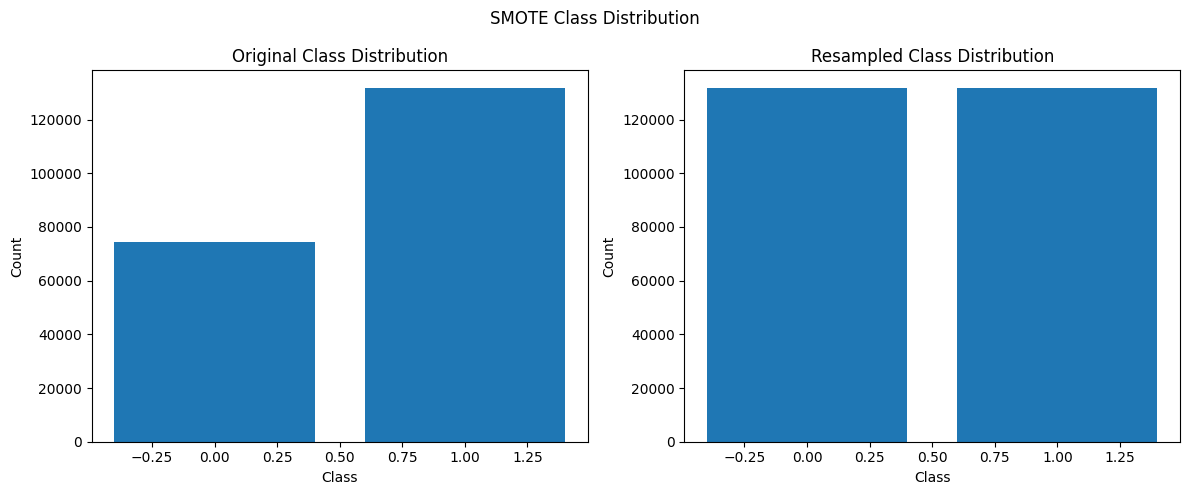

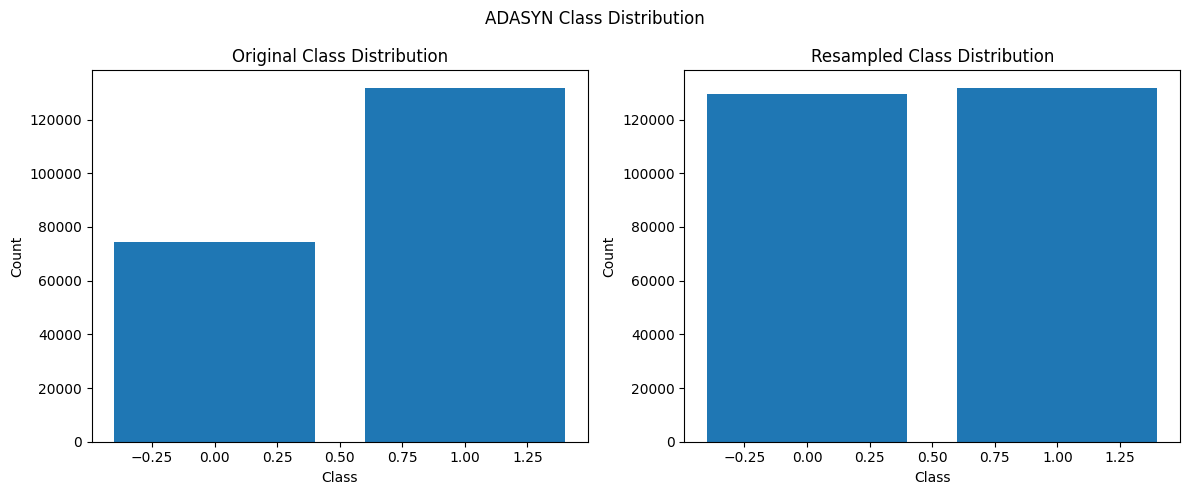

C:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


1611/1611 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


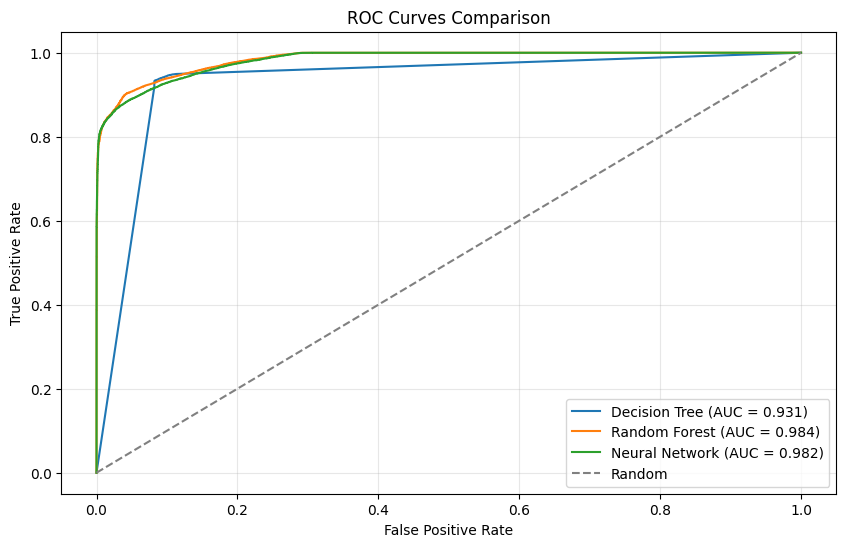

C:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


1611/1611 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


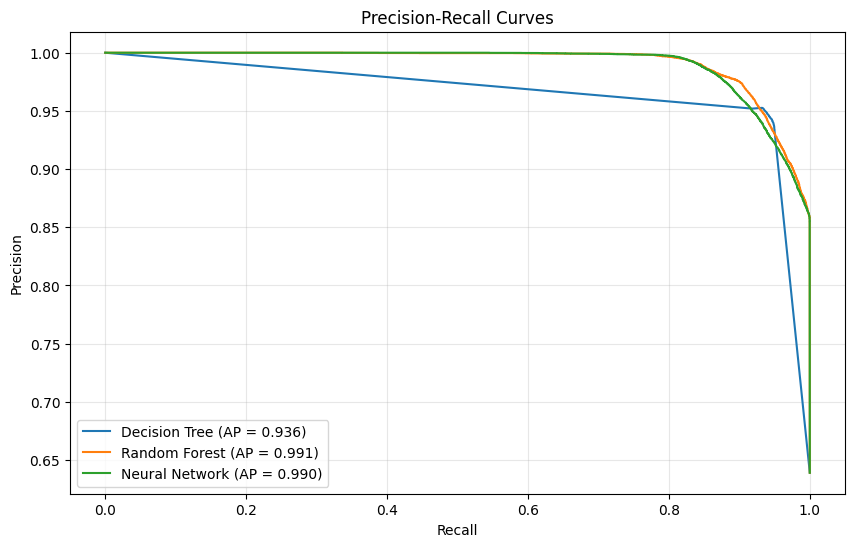

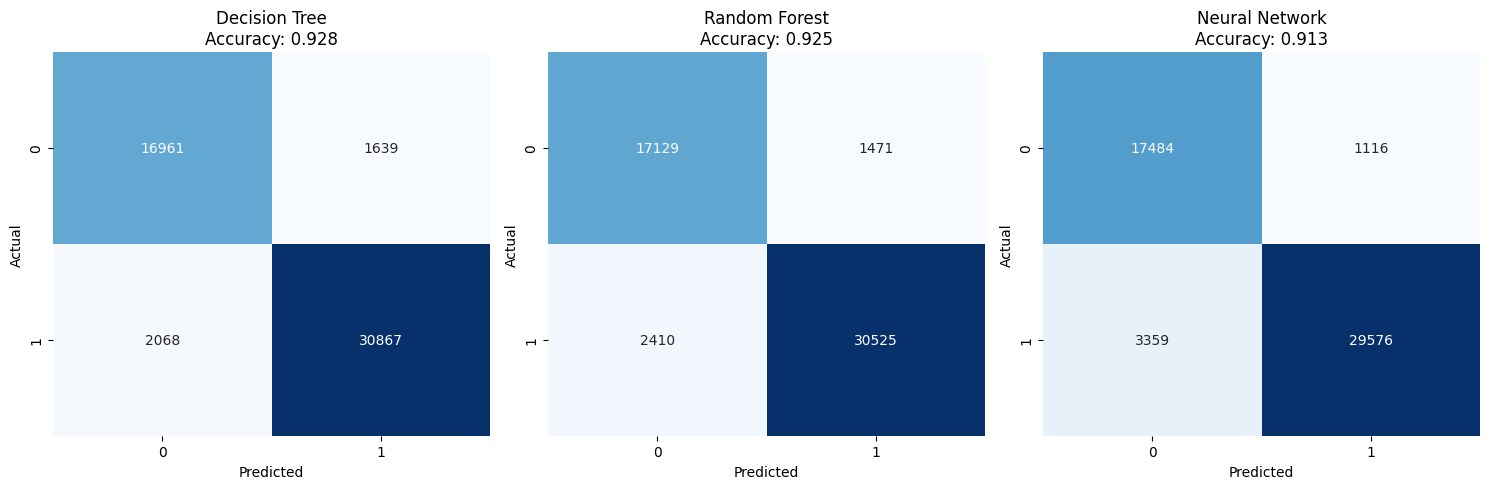

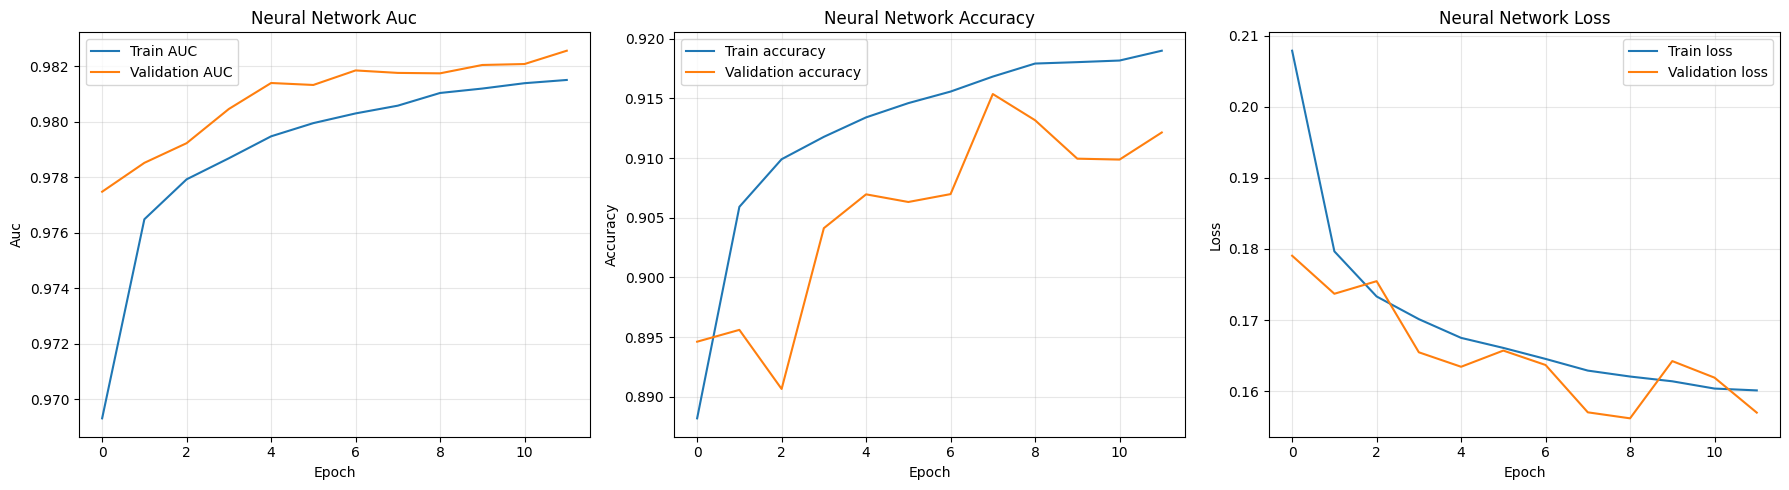


Metrics Comparison:
                Original_precision  Original_recall  Original_f1  \
Decision Tree             0.945570         0.942584     0.944074   
Random Forest             0.876415         0.991772     0.930532   
Neural Network            0.933025         0.944102     0.938531   

                Original_specificity  Original_accuracy  Original_auc_roc  \
Decision Tree               0.903925           0.928631          0.930179   
Random Forest               0.752366           0.905365          0.984382   
Neural Network              0.880000           0.920966          0.983165   

                Original_auc_pr  Original_cv_accuracy_mean  \
Decision Tree          0.934567                   0.927243   
Random Forest          0.991331                   0.906859   
Neural Network         0.990733                        NaN   

                Original_cv_accuracy_std  SMOTE_precision  ...  \
Decision Tree                   0.001266         0.952821  ...   
Random Forest   

In [6]:
# Initialize classes
model_comparator = NetworkIntrusionModelComparator(random_state=42)
oversampler = Oversampling(random_state=42)

# First, preprocess your data using your existing method
X_train, X_test, y_train, y_test = model_comparator.preprocess_data(df)

# Apply SMOTE
X_train_smote, y_train_smote = oversampler.smote(X_train, y_train)

# Apply ADASYN
X_train_adasyn, y_train_adasyn = oversampler.adasyn(X_train, y_train)

# Train and evaluate with original data
model_comparator.X_train = X_train
model_comparator.y_train = y_train
model_comparator.train_models()
original_metrics = model_comparator.evaluate_models()

# Train and evaluate with SMOTE data
model_comparator.X_train = X_train_smote
model_comparator.y_train = y_train_smote
model_comparator.train_models()
smote_metrics = model_comparator.evaluate_models()

# Train and evaluate with ADASYN data
model_comparator.X_train = X_train_adasyn
model_comparator.y_train = y_train_adasyn
model_comparator.train_models()
adasyn_metrics = model_comparator.evaluate_models()

# Visualize results
# Class distribution plots
oversampler.plot_class_distribution(y_train, y_train_smote, "SMOTE Class Distribution")
plt.show()
oversampler.plot_class_distribution(y_train, y_train_adasyn, "ADASYN Class Distribution")
plt.show()

# Plot ROC curves and other metrics using your existing methods
model_comparator.plot_roc_curves()
plt.show()
model_comparator.plot_precision_recall_curves()
plt.show()
model_comparator.plot_confusion_matrices()
plt.show()
model_comparator.plot_learning_curves()
plt.show()

# Compare metrics from different approaches
comparison_df = pd.concat([
    original_metrics.add_prefix('Original_'),
    smote_metrics.add_prefix('SMOTE_'),
    adasyn_metrics.add_prefix('ADASYN_')
], axis=1)

print("\nMetrics Comparison:")
print(comparison_df)

In [50]:
from tensorflow import keras

def save_model(model_comparator, method_name="Original"):
    """
    Save the neural network model from the model comparator
    
    Args:
        model_comparator: NetworkIntrusionModelComparison instance
        method_name: String indicating which method's model to save (Original/SMOTE/ADASYN)
    """
    if "Neural Network" in model_comparator.results:
        nn_model = model_comparator.results["Neural Network"]["model"]
        filename = f"network_intrusion_{method_name.lower()}.keras"
        nn_model.save(filename)
        print(f"Model saved as {filename}")
        return filename
    else:
        print("No Neural Network model found in results")
        return None

def load_model(filename):
    """
    Load the saved neural network model
    
    Args:
        filename: Name of the saved model file
    """
    return keras.models.load_model(filename)

# Save models for each method
original_model_file = save_model(model_comparator, "Original")
smote_model_file = save_model(model_comparator, "SMOTE")
adasyn_model_file = save_model(model_comparator, "ADASYN")
# You can also save SMOTE and ADASYN models if needed

# Load the model
# loaded_model = load_model(original_model_file)
loaded_model=load_model(smote_model_file)

# Verify the loaded model works
if q is not None:
    # Make predictions using the loaded model
    predictions = loaded_model.predict(model_comparator.X_test)
    print("Model loaded successfully!")

Model saved as network_intrusion_original.keras
Model saved as network_intrusion_smote.keras
Model saved as network_intrusion_adasyn.keras
1611/1611 ━━━━━━━━━━━━━━━━━━━━ 1s 791us/step
Model loaded successfully!


In [51]:
loaded_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                      │ (None, 128)                 │          24,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 103,685 (405.02 KB)

 Trainable params: 34,561 (135.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 69,124 (270.02 KB)

In [36]:
sample_input = X_test[:5]  # Take 5 samples from the test set
predictions = loaded_model.predict(sample_input)

print("Predictions:", predictions)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Predictions: [[5.8922732e-01]
 [7.4861944e-01]
 [5.4958587e-06]
 [9.9844038e-01]
 [9.9999338e-01]]


In [44]:
loss, accuracy, auc = loaded_model.evaluate(X_test, y_test, verbose=2)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")
print(f"AUC: {auc}")


1611/1611 - 2s - 1ms/step - AUC: 0.9817 - accuracy: 0.9132 - loss: 0.1562
Loss: 0.1561756730079651
Accuracy: 0.913165807723999
AUC: 0.9817498326301575


In [52]:
loss, accuracy, auc = loaded_model.evaluate(X_test, y_test, verbose=2)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")
print(f"AUC: {auc}")


1611/1611 - 3s - 2ms/step - AUC: 0.9817 - accuracy: 0.9132 - loss: 0.1562
Loss: 0.1561756730079651
Accuracy: 0.913165807723999
AUC: 0.9817498326301575
